# XLNet version 1

Hate speech identification project, D7047E <br>
Binary text classification task using pretrained XLNet models

In [ ]:
""" 
%pip install numpy
%pip install torch
%pip install torchvision
%pip install sentencepiece
%pip install transformers
%pip install datasets
%pip install evaluate
%pip install accelerate
%pip install imbalanced-learn
"""

# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
import torchvision

# Hugging Face
from transformers import XLNetConfig, XLNetTokenizer, XLNetForSequenceClassification
from transformers import TrainingArguments, Trainer
from datasets import Dataset
import datasets
import evaluate

# Misc
from tqdm import tqdm, trange
import sentencepiece as spm
import pandas as pd
import numpy as np
import os
from matplotlib import pyplot as plt
from imblearn.over_sampling import SMOTE

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"using {device}")

if torch.cuda.is_available(): torch.cuda.empty_cache()

In [ ]:
# Constants and vars

# aux files
path_tr = r"..\\OLID_Tain.txt" 
path_te_a = r"..\\OLID_TEST.txt" 
path_spm = r"data\\proj_xlnet" # +.model / +.vocab
path_output = r"trained\\"

# Constants
GLOBAL_SEED = 1337
TOKENIZER_MAX_LENGTH = 128 #100 works with 1 epoch 
torch.manual_seed(GLOBAL_SEED)

tokenizer_config = {
    "padding": "max_length", 
    "truncation": "longest_first",
    "max_length": TOKENIZER_MAX_LENGTH,
    #"add_special_tokens": True,
    #"return_tensors": "pt",
    #"return_token_type_ids": False, 
    #"return_attention_mask": True, 
    #"pad_to_max_length": False
}

In [ ]:
tokenizer = XLNetTokenizer.from_pretrained(
    'xlnet-base-cased',
    #additional_special_tokens = ["@USER"], NOTE THIS LINE RUINS EVERYTHING
    # ^ this note was written at 1:30 am on a tuesday
    device=device
)

def tokenize_examples(examples):
    return tokenizer(examples["text"], **tokenizer_config)

In [ ]:
# Load and split dataset
olid_dataset = pd.read_csv(path_tr, sep="\t", names=["id","text","label","other_1","other_2"])
olid_dataset = olid_dataset.drop(axis=0, index=0) # Remove column names
olid_dataset = olid_dataset.drop(axis=1, labels=["id", "other_1", "other_2"]).to_dict()
for i in trange(len(olid_dataset["label"])):
    olid_dataset["label"][i+1] = 1 if olid_dataset["label"][i+1] == "OFF" else 0 

olid_dataset = {
    "label": [y for y in olid_dataset["label"].values()],
    "text": [x for x in olid_dataset["text"].values()]     
}

olid_dataset = Dataset.from_dict(olid_dataset)
olid_dataset = olid_dataset.map(tokenize_examples, batched=True)
print(olid_dataset)

In [ ]:
def _get_split(s):
    return [int(x * olid_dataset.num_rows) for x in s]
    
split = _get_split([0.7, 0.1, 0.2])
olid_train = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[0]))
olid_val = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[1]))
olid_test = olid_dataset.shuffle(seed=GLOBAL_SEED).select(range(split[2]))
print(olid_train)
print(olid_val)
print(olid_test)


In [38]:
# Prevent overfitting by oversampling class 1
sm = SMOTE()

X = olid_train["input_ids"]
y = olid_train["label"]

X = np.array(X)
y = np.array(y)

X_res, y_res = sm.fit_resample(X, y)
print(X_res.shape, X.shape)

X_res = [tokenizer.decode(X_res[i], skip_special_tokens=True) for i in range(len(X_res))]

olid_train_os = Dataset.from_dict({"text": X_res, "label":y_res})
olid_train_os = olid_train_os.map(tokenize_examples, batched=True)

Map:   0%|          | 0/12412 [00:00<?, ? examples/s]

In [39]:
def getTrainLabelDistrib(loader):
    labels_dist = {}
    for e in loader:
        lab = e["label"]
        if lab in labels_dist:
            labels_dist[lab] += 1
        else:
            labels_dist[lab] = 0
    print(labels_dist)

In [40]:
#getTrainLabelDistrib(olid_test)
#getTrainLabelDistrib(olid_train)
#getTrainLabelDistrib(olid_val)
getTrainLabelDistrib(olid_train_os)

{0: 6205, 1: 6205}


In [41]:
# Model 
# docs: https://huggingface.co/docs/transformers/model_doc/xlnet

xlnet_model = XLNetForSequenceClassification.from_pretrained(
    "xlnet-base-cased", 
    num_labels=2
)
xlnet_model.to(device)

print(xlnet_model.config)
print(next(xlnet_model.parameters()).is_cuda)

Some weights of XLNetForSequenceClassification were not initialized from the model checkpoint at xlnet-base-cased and are newly initialized: ['logits_proj.bias', 'logits_proj.weight', 'sequence_summary.summary.bias', 'sequence_summary.summary.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


XLNetConfig {
  "_name_or_path": "xlnet-base-cased",
  "architectures": [
    "XLNetLMHeadModel"
  ],
  "attn_type": "bi",
  "bi_data": false,
  "bos_token_id": 1,
  "clamp_len": -1,
  "d_head": 64,
  "d_inner": 3072,
  "d_model": 768,
  "dropout": 0.1,
  "end_n_top": 5,
  "eos_token_id": 2,
  "ff_activation": "gelu",
  "initializer_range": 0.02,
  "layer_norm_eps": 1e-12,
  "mem_len": null,
  "model_type": "xlnet",
  "n_head": 12,
  "n_layer": 12,
  "pad_token_id": 5,
  "reuse_len": null,
  "same_length": false,
  "start_n_top": 5,
  "summary_activation": "tanh",
  "summary_last_dropout": 0.1,
  "summary_type": "last",
  "summary_use_proj": true,
  "task_specific_params": {
    "text-generation": {
      "do_sample": true,
      "max_length": 250
    }
  },
  "transformers_version": "4.40.2",
  "untie_r": true,
  "use_mems_eval": true,
  "use_mems_train": false,
  "vocab_size": 32000
}

True


In [42]:
# Fine-tuning
# https://huggingface.co/docs/transformers/training

metric = evaluate.load("accuracy")
def compute_model_metrics(eval_pred):
    global metric
    logits, labels = eval_pred
    preds = np.argmax(logits, axis=1)
    return metric.compute(predictions=preds, references=labels)


device_batch_size = 32
calc_steps = len(olid_train_os) // device_batch_size // 5


tr_args = TrainingArguments(
    do_train=True, do_eval=True, evaluation_strategy="epoch", output_dir=path_output,
    
    logging_steps=calc_steps, # For larger size dataset
    eval_accumulation_steps=10, # To prevent cuda OOM after training
    per_device_eval_batch_size=device_batch_size,
    per_device_train_batch_size=device_batch_size,
    bf16=True, 
    #fp16=True,

    num_train_epochs = 3, 
    weight_decay=0.1,
    save_strategy="no",
    # use_cpu=True
)


trainer = Trainer(
    model=xlnet_model,
    args=tr_args,
    train_dataset=olid_train,
    eval_dataset=olid_val,
    compute_metrics=compute_model_metrics
)
trainer.train()

  0%|          | 0/870 [00:00<?, ?it/s]

{'loss': 0.5864, 'grad_norm': 6.2802042961120605, 'learning_rate': 4.557471264367816e-05, 'epoch': 0.27}
{'loss': 0.5006, 'grad_norm': 3.641277313232422, 'learning_rate': 4.1149425287356325e-05, 'epoch': 0.53}
{'loss': 0.4948, 'grad_norm': 6.483986854553223, 'learning_rate': 3.672413793103448e-05, 'epoch': 0.8}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.37510573863983154, 'eval_accuracy': 0.8557401812688822, 'eval_runtime': 4.117, 'eval_samples_per_second': 321.593, 'eval_steps_per_second': 10.202, 'epoch': 1.0}
{'loss': 0.455, 'grad_norm': 3.6640496253967285, 'learning_rate': 3.229885057471265e-05, 'epoch': 1.06}
{'loss': 0.3981, 'grad_norm': 6.977750778198242, 'learning_rate': 2.787356321839081e-05, 'epoch': 1.33}
{'loss': 0.3935, 'grad_norm': 2.7005958557128906, 'learning_rate': 2.3448275862068967e-05, 'epoch': 1.59}
{'loss': 0.3933, 'grad_norm': 6.777024745941162, 'learning_rate': 1.9022988505747128e-05, 'epoch': 1.86}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.2685081660747528, 'eval_accuracy': 0.9018126888217523, 'eval_runtime': 3.915, 'eval_samples_per_second': 338.187, 'eval_steps_per_second': 10.728, 'epoch': 2.0}
{'loss': 0.3632, 'grad_norm': 5.160616874694824, 'learning_rate': 1.459770114942529e-05, 'epoch': 2.12}
{'loss': 0.2805, 'grad_norm': 4.600411891937256, 'learning_rate': 1.0172413793103449e-05, 'epoch': 2.39}
{'loss': 0.2776, 'grad_norm': 5.239594459533691, 'learning_rate': 5.747126436781609e-06, 'epoch': 2.66}
{'loss': 0.2822, 'grad_norm': 6.391677379608154, 'learning_rate': 1.3218390804597702e-06, 'epoch': 2.92}


  0%|          | 0/42 [00:00<?, ?it/s]

{'eval_loss': 0.1885427087545395, 'eval_accuracy': 0.9358006042296072, 'eval_runtime': 3.928, 'eval_samples_per_second': 337.067, 'eval_steps_per_second': 10.692, 'epoch': 3.0}
{'train_runtime': 229.3828, 'train_samples_per_second': 121.212, 'train_steps_per_second': 3.793, 'train_loss': 0.3990607880997932, 'epoch': 3.0}


TrainOutput(global_step=870, training_loss=0.3990607880997932, metrics={'train_runtime': 229.3828, 'train_samples_per_second': 121.212, 'train_steps_per_second': 3.793, 'total_flos': 1980202823165952.0, 'train_loss': 0.3990607880997932, 'epoch': 3.0})

In [43]:
predictions = trainer.predict(olid_test)
print(predictions.predictions.shape, predictions.label_ids.shape) 
preds = np.argmax(predictions.predictions, axis=-1)

labels_t = {"0":0, "1":0}
labels_p = {"0":0, "1":0}
for i in range(len(predictions.predictions)):
    #print(predictions.label_ids[i], preds[i], predictions.predictions[i]) # Debug overfitting
    labels_t[str(predictions.label_ids[i])] += 1
    labels_p[str(preds[i])] += 1
print(f"True labels {labels_t}")
print(f"Predicted labels {labels_p}")

loss_his = {"tr_loss":[], "val_loss":[]}

for e in trainer.state.log_history:
    if "loss" in e:
        loss_his["tr_loss"].append(e["loss"])
    elif "eval_loss" in e:
        loss_his["val_loss"].append(e["eval_loss"])

metric = evaluate.combine(["accuracy", "f1", "precision", "recall", "BucketHeadP65/confusion_matrix"])
metric.compute(predictions=preds, references=predictions.label_ids)

  0%|          | 0/83 [00:00<?, ?it/s]

(2648, 2) (2648,)
True labels {'0': 1778, '1': 870}
Predicted labels {'0': 1743, '1': 905}


{'accuracy': 0.9369335347432024,
 'f1': 0.9059154929577464,
 'precision': 0.8883977900552487,
 'recall': 0.9241379310344827,
 'confusion_matrix': array([[1677,  101],
        [  66,  804]], dtype=int64)}

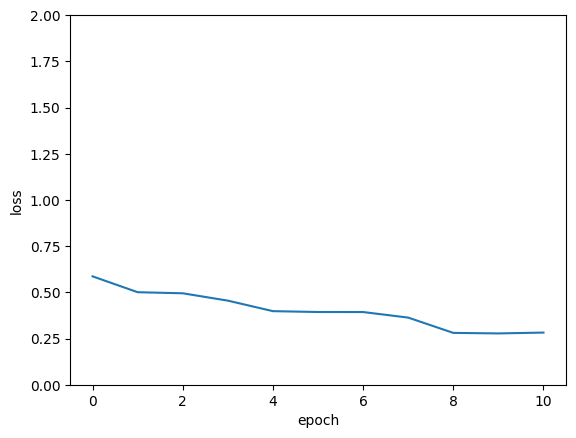

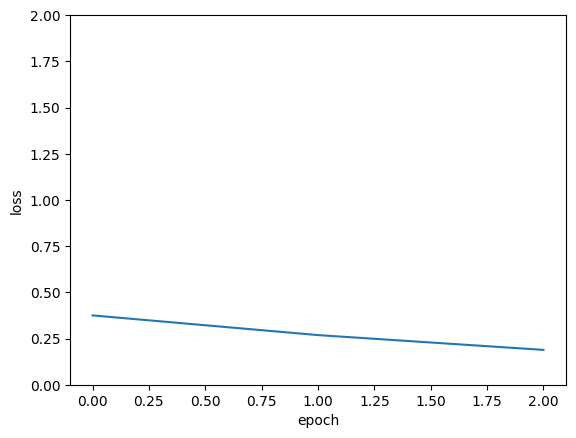

In [44]:
plt.plot(loss_his["tr_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()

plt.plot(loss_his["val_loss"], label="tr_loss")
plt.ylabel('loss')
plt.xlabel('epoch')
plt.ylim([0,2])
plt.show()